This section shows how the vision works to detect the thymio and the labyrinth. As mentionned before, it uses extensively the ArUco codes to locate the 4 corners of the labyrinth and the Thymio. The ArUco utilities are not available in the standard OpenCV distribution. `opencv-contrib-python` needs to be installed in order to run the code.

Various constants are set such as which ArUco dictionary is used, the dimensions of the transformed image, the ArUco ids of the corner in the correct order, the threshold by which a component is considered as a wall. The dimensions of the transformed image are based on the A0 paper ratio so that a square in world space would remain a square in image space.

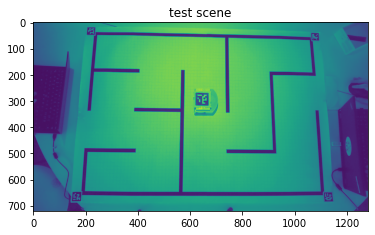

In [1]:
import numpy as np
import cv2 as cv
import cv2.aruco as aruco
import matplotlib.pyplot as plt

# ArUco dictionary
dict_id = aruco.DICT_6X6_50
arucoDict = aruco.Dictionary_get(dict_id)
arucoParams = cv.aruco.DetectorParameters_create()

## A0 paper ratio
res_w = 720
res_h = 1020

# Corners dictionary
corner_ids = {
    10: 3,
    8: 2,
    15: 0,
    6: 1,
}

# Vision thresholds
WALL_THRESHOLD = 5000

# Load test image
img = cv.imread("images/example_scene.jpg")
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

plt.imshow(img_gray)
plt.title('test scene')
plt.show()

On the image, the visible objects are:
* The labyrinth with the printed walls on a A0 paper
* The ArUcos on the 4 corners which allow to flatten the perspective
* The Thymio with an ArUco on top of it

Running the ArUco utilities, it's possible to confirm that they are detected by opencv. 
The size can be suprisingly small on the image and they are still detected. On contrary,
if even a small part of the code is ocluded, it's not detected anymore.

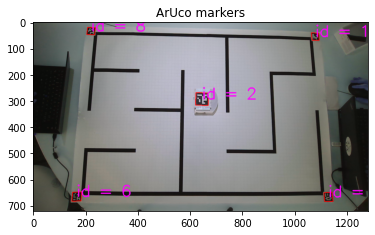

In [2]:
img_detected = img.copy()

(corners, ids, rejected) = cv.aruco.detectMarkers(img_detected, arucoDict,
    parameters=arucoParams)

for i, id in enumerate(ids):
    c = np.int32(corners[i][0])
    center = (c[0]+c[1]+c[2]+c[3])//4
    for i in range(4):
        cv.line(img_detected, tuple(c[i]), tuple(c[(i+1)%4]), (255, 0, 0), 2)
    cv.putText(img_detected, f'id = {id[0]}', tuple(center), cv.FONT_HERSHEY_SIMPLEX, 2, (255, 0, 255), 4)
    
plt.imshow(img_detected)
plt.title('ArUco markers')
plt.show()

Now having the knowledge of the 4 corners, it's possible to compute
a perspective transform matrix which will flatten the labyrinth. This process
is done once at the beginning because the camera should in principle not
move during the program run.

The `vision_utils` has a function to detect all ArUco on the image. This should be
done once per frame so that the detected positions is passed to other functions
for use in different recognition processes.

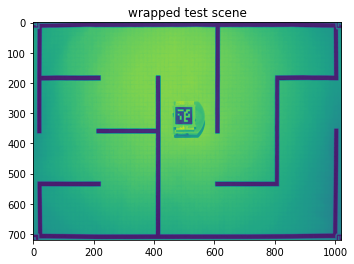

In [3]:
# Detect all AruCo in image
def detect_aruco(img):
  detected = cv.aruco.detectMarkers(img, arucoDict,
    parameters=arucoParams)
  return detected 

# Get position of ArUco marker
def get_pos_aruco(detected, search_id):
  (corners, ids, rejected) = detected

  if ids is not None:
    for i, id in enumerate(ids):
      c = corners[i][0]
      if id[0] == search_id:
        center = (c[0]+c[1]+c[2]+c[3])/4
        return (center, c)
  return (None, None)

# Get perspective transform from img from ArUco corners
# Returns none if corners are not detected
def get_labyrinth_perspective(img):
  detected = detect_aruco(img)

  cs = [None]*4
  for (id, idx) in corner_ids.items():
    (center, _) = get_pos_aruco(detected, id)
    if center is not None:
      cs[idx] = center
    else:
      return None

  # Do perspective correction
  pts1 = np.array([cs[0], cs[1], cs[3], cs[2]])
  pts2 = np.float32([[res_h,res_w], [0, res_w], [res_h, 0], [0, 0]])

  return cv.getPerspectiveTransform(pts1,pts2)

# Given perspective transform, crops the original image
def crop_labyrinth(img, M):
    return cv.warpPerspective(img,M,(res_h,res_w))

# M is the perspective transformation matrix
M = get_labyrinth_perspective(img_gray)
transformed = crop_labyrinth(img_gray, M)

plt.imshow(transformed)
plt.title('wrapped test scene')
plt.show()

This allowed to retrieve an image as if the camera is placed above. As explained later, this is still not good because there are some apparent distortion effect. The ArUco on the Thymio has a slight offset depending on the position because of perspective. But the image of the labyrinth is now flat.

The next step is to extract the walls which are then passed to the navigation module. First, an adaptive threshold is applied. The kernel size should be large enough so that the walls are recognized in one piece. But before that, because the ArUco could be detected as walls and the positions are known, they are removed from the image. Then an adaptive threshold is applied.

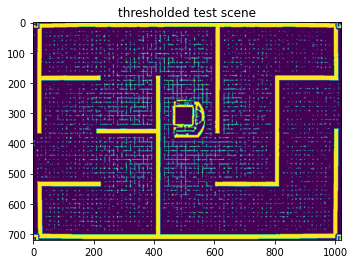

In [4]:
def erase_aruco(img, detected):
    (corners, _, _) = detected

    if corners is not None:
        for i in range(len(corners)):
            c = np.int32(corners[i][0])

            # Remove AruCo
            cv.drawContours(img, [c], 0, 255, -1)

thresholded = transformed.copy()
detected = detect_aruco(thresholded)
erase_aruco(thresholded, detected)

# Threshold
thresholded = cv.adaptiveThreshold(thresholded,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY_INV,31,2)

plt.imshow(thresholded)
plt.title('thresholded test scene')
plt.show()

To remove, the remaining noise, an morphological opening is applied. The kernel
size is kept small to avoid damaging the detected walls. 

The noise produced the Thymio's shadow is still apparent afterwards. It was
decided to use opencv's `connectedComponentsWithStats` to get the image components
and remove any components which has an area below a threshold. 
This image processing algorithm works usually well in normal lighting conditions.

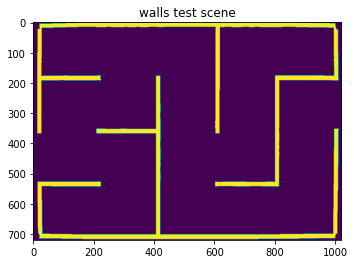

In [5]:
walls = thresholded.copy()

# Remove noise
kernel = np.ones((5,5),np.uint8)
walls = cv.morphologyEx(walls, cv.MORPH_OPEN, kernel)

# Detect connected components
num_labels, labels, stats, _ = cv.connectedComponentsWithStats(walls, 8, cv.CV_32S)

# Pick wall components
result = np.zeros_like(walls)
for i in range(1, num_labels):
    if stats[i, cv.CC_STAT_AREA] > WALL_THRESHOLD:
        result[labels == i] = 255


plt.imshow(result)
plt.title('walls test scene')
plt.show()

The last operation is to dilate the walls. This simple trick allows the navigation
module to simply find a path, and not worry about the Thymio being too close to the
walls. The walls are first slightly dilated, this connects any walls which could
have been disconnected because of noise.

The walls are then dilated until the number of connected changes. The labyrinth is
actually two connected components, if it's too dilated, it becomes one connected component,
and the algorithm stops. 

It accepts a `wall_margin` argument. This is the margin for dilation, if the space
between is too small, it could become impossible to pass when the image is resized
to a small image for navigation. Thus a large enough margin is kept.

At the end, the walls are also dilated independently horizontally and vertically.
The image could be distorded and need more dilation in one direction.

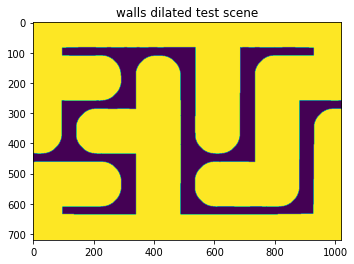

In [6]:
def dilate_walls_max(img, init_wall_size, wall_inc, wall_margin):
    wall_size = init_wall_size

    num_components_previous, _, _, _ = cv.connectedComponentsWithStats(img, 8, cv.CV_32S)

    # Check that the dilate at first doesn't affect the connected components
    # count
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(wall_size[0]+wall_margin[0], wall_size[1]+wall_margin[1]))
    dilated = cv.dilate(img,kernel,iterations = 1)

    num_labels, _, _, _ = cv.connectedComponentsWithStats(dilated, 8, cv.CV_32S)

    if num_labels < num_components_previous:
        return img

    # Dilate by increment and check that the number of 
    # connected components stay the same
    while True:
        wall_size[0] += wall_inc[0]
        wall_size[1] += wall_inc[1]

        kernel =cv.getStructuringElement(cv.MORPH_ELLIPSE,(wall_size[0]+wall_margin[0], wall_size[1]+wall_margin[1]))
        dilated = cv.dilate(img,kernel,iterations = 1)

        num_labels, _, _, _ = cv.connectedComponentsWithStats(dilated, 8, cv.CV_32S)

        if num_components_previous > num_labels:
            wall_size[0] -= wall_inc[0]
            wall_size[1] -= wall_inc[1]

            kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,wall_size)
            return cv.dilate(img,kernel,iterations = 1)

        num_components_previous = num_labels

final = result.copy()
# Dilate walls first to connect disconnected walls
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(70, 70))
final = cv.dilate(final,kernel,iterations = 1)
final = dilate_walls_max(final, [5, 5], [10, 10], [20, 20])

final = dilate_walls_max(final, [5, 5],[10, 0], [20, 20])
final = dilate_walls_max(final, [5, 5], [0, 10], [20, 20])

plt.imshow(final)
plt.title('walls dilated test scene')
plt.show()

This concludes the detection of the labyrinth's walls. The image is then reduced and passed directly to the navigation module. 

It was briefly mentionned before, the Thymio's detected position is distorded due to perspective. This is corrected using a manual offset calibration. The offset is then interpolated when the thymio is on the labyrinth. The following codes will first compute the Thymio's position.

[-3.5620759   9.91029308]


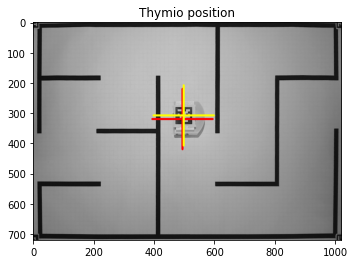

The yellow cross is the ArUco detected position
The red cross is the position with the perspective correction offset


In [11]:
import pickle
from scipy.interpolate import LinearNDInterpolator

# Ids
thymio_id = 2

# Given the ID, gives the position, angle of the Thymio
# assuming an ArUco is put on top of it
def localize_thymio(detected):
    # Detect aruco
    (center, c) = get_pos_aruco(detected, thymio_id)
    
    if center is None:
        return (None, None, None)
    
    # c[0]        TOP LEFT
    # c[1]        BOTTOM RIGHT
    # c[2]        BOTTOM LEFT
    # c[3]        TOP LEFT
    # Compute orientation
    top_middle = (c[0]+c[3])/2
    dir = top_middle - center
    angle = np.arctan2(dir[0], dir[1])
    
    return (c, center, angle)

def load_z_offset_data(path):
    global offset_interp

    f = open(path, "rb")
    saved = pickle.load(f)

    (thymio_pos, offset_pos) = saved

    offset_interp = LinearNDInterpolator(thymio_pos, offset_pos, 0)

# Once load_z_offset_data() has been loaded
# this function can be called to get an interpolated offset
# to estimate the Thymio position on the group
def get_z_offset(center):
    if offset_interp is not None:
        return offset_interp(center[0], center[1])
    else:
        print("No interpolator for z offset (please use load_z_offset_data() first)")
        return [0, 0]
    
def transform_perspective_point(M, p):
  px = (M[0,0]*p[0] + M[0,1]*p[1] + M[0,2]) / ((M[2,0]*p[0] + M[2,1]*p[1] + M[2,2]))
  py = (M[1,0]*p[0] + M[1,1]*p[1] + M[1,2]) / ((M[2,0]*p[0] + M[2,1]*p[1] + M[2,2]))
  return (px, py)

load_z_offset_data("data/z_offset.bin")

thymio_loc = cv.cvtColor(transformed, cv.COLOR_GRAY2BGR)
detected = detect_aruco(img)
(_, center, _) = localize_thymio(detected)

offset = get_z_offset(center)
print(offset)
offset_center = center + np.array(offset)

# Important! the point needs to be transformed with
# the perspective matrix.
offset_center = transform_perspective_point(M, offset_center)

cv.drawMarker(thymio_loc, np.int32(offset_center), (255, 0, 0), markerSize=200, thickness=5)

# Get  center position on AruCo
detected = detect_aruco(transformed)
(_, center, _) = localize_thymio(detected)

cv.drawMarker(thymio_loc, np.int32(center), (255, 255, 0), markerSize=200, thickness=5)

plt.imshow(thymio_loc)
plt.title('Thymio position')
plt.show()

print("The yellow cross is the ArUco detected position")
print("The red cross is the position with the perspective correction offset")

The offset calibration data is done manually before using the script `vision/calibrate_offset.py`.
The general principle for the vision's algorithms was explained. For more details, please refer to `vision/vision_utils.py`.